In [1]:
name = 'tf_targeting_percentage_of_volume'
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-notebook')    
from numba import vectorize
import os
import time


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout
from keras import backend as K
tf.reset_default_graph()
os.environ["CUDA_VISIBLE_DEVICES"] = ""
K.clear_session()
num_paths=10

Using TensorFlow backend.


In [2]:
N = 100 # time steps
T = 1. # time horizon
sigma = 0.2 # volatility
alpha = 0.6 # temporary price impact
dt = T/N
num_samples = 1000
num_shares = 1.
b = 0. # permanent market impact
mu_0 = 0.3


batch_size = 64
price_limit = -1000.
phi = 0
psi = 40. # deviation from trading rate penalty
ro = 0.2 # percentage of targeted market trading_rate
beta = 10.
version = 1
n_batches = num_samples // batch_size

## Parameters of the network

In [3]:
params = {"hidden1": 100, "hidden2": 100,  
              "hidden3": 66, 
              "droput1":0.45,  "droput2": 0.3,
              "optimizer": 'rmsprop', "epochs": 20}

## Generate the data

In [4]:
import h5py

In [5]:
hf = h5py.File('ex_data.h5', 'r')
ex_data = hf.get('ex_data')
ex_data = np.array(ex_data)
hf.close()
ex_data = 3 + 1. * ex_data[:num_samples, :N]

In [6]:
ex_data.shape

(1000, 100)

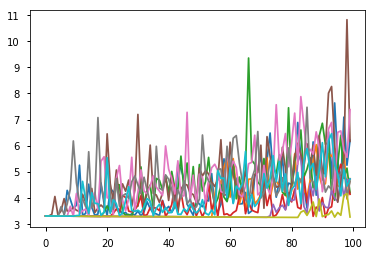

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
for j in range(min(ex_data.shape[0],10)):
    plt.plot(ex_data[j])

In [8]:
data = np.random.normal(0, 1, (num_samples, N))*np.sqrt(dt)
timesteps = np.linspace(0, T-dt, N)
timeline = np.zeros_like(data)
timeline[:] = timesteps
timeline.shape

(1000, 100)

In [9]:
data.shape

(1000, 100)

In [10]:
X_data = np.zeros((data.shape[0],4))
X_data[:] = [0., 0., num_shares, mu_0]

In [11]:
X_data[:10]

array([[0. , 0. , 1. , 0.3],
       [0. , 0. , 1. , 0.3],
       [0. , 0. , 1. , 0.3],
       [0. , 0. , 1. , 0.3],
       [0. , 0. , 1. , 0.3],
       [0. , 0. , 1. , 0.3],
       [0. , 0. , 1. , 0.3],
       [0. , 0. , 1. , 0.3],
       [0. , 0. , 1. , 0.3],
       [0. , 0. , 1. , 0.3]])

## Building the computational graph


Utility function for comuting temporary market impact

In [12]:
def tf_power(alpha):
    def f(x):
        return tf.pow(x, alpha)
    return f

In [13]:
X = tf.placeholder(shape=[None, 4], dtype=tf.float32)
noise = tf.placeholder(shape=[None, N], dtype=tf.float32)
tr = tf.placeholder(shape=[None, N], dtype=tf.float32)
# time, current_price, shares remaining to buy, trading_rate

def speed(X):
    hidden1 = tf.layers.dense(inputs = X, units=params["hidden1"], activation=tf.nn.relu)
    dropout1 = tf.layers.dropout(inputs=hidden1, rate=0.2)
    hidden2 = tf.layers.dense(inputs = dropout1, units=params["hidden2"], activation=tf.nn.relu)
    logit = tf.layers.dense(inputs = hidden2, units=1, activation=None)
    trading_speed = tf.nn.softplus(logit)
    return trading_speed

In [14]:
trading_speed = speed(X)
temporary_impact_function = tf_power(alpha)
price_impact = temporary_impact_function(trading_speed)

In [15]:
### tensors of [None, ] shape
current_time = tf.zeros_like(X[:,0:1])
current_price  = tf.zeros_like(X[:,0:1])
shares_remaining_to_sell = num_shares * tf.ones_like(X[:,0:1])
current_trading_rate = mu_0 * tf.ones_like(X[:,0:1])

current_input = tf.concat([current_time, 
                           current_price, 
                           shares_remaining_to_sell,
                           current_trading_rate], axis=1)

In [16]:
running_cash_from_sell = tf.zeros_like(X[:,0:1])
terminal_sell_cash = tf.zeros_like(X[:,0:1])
running_inventory_penalty = tf.zeros_like(X[:,0:1])
running_tr_penalty = tf.zeros_like(X[:,0:1])

price_limit_tensor = price_limit * tf.ones_like(X[:,0:1])

Path tensors needed for further calculations

In [17]:
path_running_cash_from_sell = running_cash_from_sell

path_running_inventory_penalty = running_inventory_penalty
path_current_price = current_price
path_current_speed = tf.zeros_like(X[:,0:1])
path_shares_remaining_to_sell = shares_remaining_to_sell
path_running_tr_penalty = running_tr_penalty
path_terminal_sell_cash = terminal_sell_cash

## Unroll the time loop of trade execution

In [18]:
for j in range(N):
    current_speed = speed(current_input)
    path_current_speed = tf.concat([path_current_speed, current_speed], axis=1)
    current_price_impact = temporary_impact_function(current_speed)
    price_move = np.sqrt(sigma) * noise[:, j:j+1] - b*current_speed 
    current_trading_rate = tr[:, j:j+1]
    
    current_time = dt * j * tf.ones_like(current_speed)#tf.timeline[:batch_size, j+1:j+2]
    current_price = tf.add(current_price, price_move)
    current_price_of_execution = current_price - current_price_impact
    current_inventory_penalty = dt * phi * tf.square(shares_remaining_to_sell)
    current_tr_penalty = dt * psi * tf.square(current_speed - ro * current_trading_rate)
    terminal_sell_cash = tf.multiply(shares_remaining_to_sell, tf.subtract(current_price, 
                                                                        beta * shares_remaining_to_sell))
    
    # we update the number of shares remaing to be bought
    shares_remaining_to_sell = tf.subtract(shares_remaining_to_sell, dt * current_speed)
    path_shares_remaining_to_sell = tf.concat([path_shares_remaining_to_sell, 
                                                 shares_remaining_to_sell], axis=1)
    #we update the current_input
    
    current_input = tf.concat([current_time, current_price, 
                               shares_remaining_to_sell, current_trading_rate], axis=1)
    
    # concatenate the paths
    
    path_current_price = tf.concat([path_current_price, current_price], axis=1)
    
    running_cash_from_sell = tf.add(running_cash_from_sell,
                                      dt * tf.multiply(current_price_of_execution, current_speed))
    path_running_cash_from_sell = tf.concat([path_running_cash_from_sell, 
                                               running_cash_from_sell], axis=1)
                                      
                                      
    running_inventory_penalty = tf.add(running_inventory_penalty, current_inventory_penalty)
    path_running_inventory_penalty = tf.concat([path_running_inventory_penalty, 
                                                running_inventory_penalty], axis=1)
    
    running_tr_penalty = tf.add(running_tr_penalty, current_tr_penalty)
    path_running_tr_penalty = tf.concat([path_running_tr_penalty,
                                        running_tr_penalty], axis=1)
    
    path_terminal_sell_cash = tf.concat([path_terminal_sell_cash, 
                                        terminal_sell_cash], axis=1)
    

In [19]:
path_running_cash_from_sell = path_running_cash_from_sell[:, 1:]
path_running_inventory_penalty = path_running_inventory_penalty[:, 1:]
path_terminal_sell_cash = path_terminal_sell_cash[:, 1:]
path_current_speed = path_current_speed[:,1:]
path_current_price = path_current_price[:, 1:]
path_shares_remaining_to_sell = path_shares_remaining_to_sell[:,1:]
path_running_tr_penalty = path_running_tr_penalty[:,1:]

## Determine the stopping time

In [20]:
path_price_limit = price_limit * tf.ones_like(path_current_price)

w = - path_current_price + path_price_limit 


def stopping_util(w):
    return tf.where(w<tf.zeros_like(w), tf.ones_like(w, dtype=tf.int32), tf.zeros_like(w,  dtype=tf.int32))

mask = stopping_util(w)
temp2 = tf.argmin(mask, axis=1)
temp1 = (N-1) * tf.ones_like(temp2, dtype=tf.int64)
stopping_time = tf.where(temp2 > tf.zeros_like(temp2), temp2, temp1)
stopping_time_ex = tf.expand_dims(stopping_time, axis=1)

def terminal(tensor, batch = batch_size):
    temp = tf.constant([0.])
    for j in range(batch):
        temp = tf.concat([temp, tensor[j:j+1,stopping_time_ex[j,0]]], axis=0)
    #res = tensor[:, stopping_time_ex[:, 0]]
    return temp[1:]

## Define the loss and choose optimizer

In [21]:
loss1 = -terminal(path_running_cash_from_sell)
loss2 = -terminal(path_terminal_sell_cash)
loss3 = terminal(path_running_tr_penalty)

loss1_batch = -tf.reduce_mean(terminal(path_running_cash_from_sell), axis=0)
loss2_batch = -tf.reduce_mean(terminal(path_terminal_sell_cash), axis=0)
loss3_batch = tf.reduce_mean(terminal(path_running_tr_penalty), axis=0)

loss = loss1_batch + loss2_batch + loss3_batch

loss_vector = loss1 + loss2 + loss3



optimize = tf.train.RMSPropOptimizer(0.001).minimize(loss)

init = tf.global_variables_initializer()

## Train the model

In [22]:
with tf.device('/cpu:0'):
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, \
                  log_device_placement=True)) as sess:
        #sess.run(tf.global_variables_initializer())
   # with tf.Session() as sess:
        # Run your code
        saver = tf.train.Saver()    
        start_global_time = time.time()
        sess.run(init)
        writer = tf.summary.FileWriter('graphs/', sess.graph)
        for epoch in range(params["epochs"]):
            
            for step in range(n_batches):
                X_batch = X_data[step * batch_size: step * batch_size + batch_size]
                noise_batch = data[step * batch_size: step * batch_size + batch_size]
                tr_batch = ex_data[step * batch_size: step * batch_size + batch_size]
                _, train_loss = sess.run([optimize, loss], feed_dict={noise: noise_batch, X: X_batch, tr: tr_batch})
            if (epoch + 1) % 2 == 0:
                time_now = time.time()
                time_per_epoch = (time_now-start_global_time)/(epoch+1)
                train_loss = sess.run([loss], feed_dict={noise: noise_batch, X: X_batch, tr: tr_batch})
                                                                     
                print('Epoch nr: ', epoch+1, ' Current loss: ', train_loss)
                print('Expected time remaining: %.2f seconds.' % (time_per_epoch * (params["epochs"] - epoch)))
                
        saver.save(sess, "./version_" + str(name))
            
        print("Training finished!")

        writer.close()

Epoch nr:  2  Current loss:  [3.0349305]
Expected time remaining: 308.90 seconds.
Epoch nr:  4  Current loss:  [2.0744705]
Expected time remaining: 160.04 seconds.
Epoch nr:  6  Current loss:  [2.0424366]
Expected time remaining: 98.07 seconds.
Epoch nr:  8  Current loss:  [2.0936542]
Expected time remaining: 66.25 seconds.
Epoch nr:  10  Current loss:  [2.0715635]
Expected time remaining: 46.87 seconds.
Epoch nr:  12  Current loss:  [2.0588489]
Expected time remaining: 33.32 seconds.
Epoch nr:  14  Current loss:  [2.0419798]
Expected time remaining: 22.99 seconds.
Epoch nr:  16  Current loss:  [2.0299559]
Expected time remaining: 14.88 seconds.
Epoch nr:  18  Current loss:  [2.0265083]
Expected time remaining: 8.25 seconds.
Epoch nr:  20  Current loss:  [2.0193915]
Expected time remaining: 2.56 seconds.
Training finished!


In [23]:
def print_paths(num_paths=10):
    with tf.device('/cpu:0'):
        with tf.Session() as sess:
            np.random.shuffle(data)
            trading_data = ex_data[:max(num_paths, batch_size)]
            feed_dict = {noise: data[:max(num_paths, batch_size)], 
                         X: X_data[:max(num_paths, batch_size)],
                         tr: ex_data[:max(num_paths, batch_size)]}
            saver.restore(sess, "./version_" + str(name))
           
            price_path = sess.run(path_current_price, feed_dict=feed_dict)
            speed_path = sess.run(path_current_speed, feed_dict=feed_dict)
            stopping_point = sess.run(stopping_time, feed_dict=feed_dict)
            total_loss = sess.run(loss_vector, feed_dict=feed_dict)
            remaining_to_sell = sess.run(path_shares_remaining_to_sell, feed_dict=feed_dict)
            #speed_relative_to_shares_to_be_bought = speed_path/remaining_to_buy
            
    import matplotlib.pyplot as plt
    plt.style.use('seaborn-dark')       
    for j in range(num_paths):
        print('Stopping_time: ', stopping_point[j])
        print('Total cost of execution:', total_loss[j])
        plt.plot(timesteps, speed_path[j], color='skyblue', label='trading_speed')
        plt.plot(timesteps, price_path[j], color='red', label='price_path')
        plt.plot(timesteps, trading_data[j], color='green', label='trading_rate')
        #plt.plot(timesteps, np.ones_like(timesteps) * price_limit, color='orange', label='price_limit')
        plt.axvline(x=stopping_point[j]/float(N), label='stopping_time')
        #plt.plot(timesteps, 0.1*speed_relative_to_shares_to_be_bought[j], color='green', label='relaive_speed')
        plt.plot(timesteps, remaining_to_sell[j], color='orange', label='shares_remaining_to_sell')
        plt.legend()
        plt.show()

INFO:tensorflow:Restoring parameters from ./version_tf_targeting_percentage_of_volume
Stopping_time:  99
Total cost of execution: 2.6275616


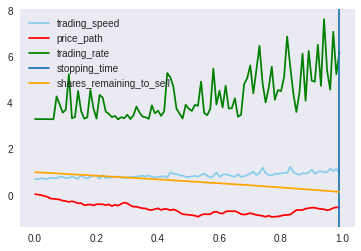

Stopping_time:  99
Total cost of execution: 1.7606776


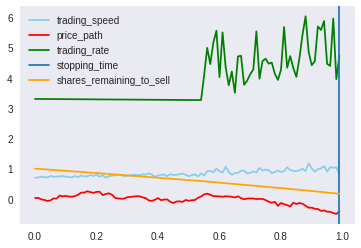

Stopping_time:  99
Total cost of execution: 2.765788


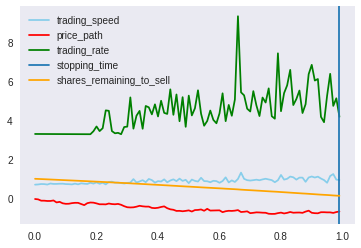

Stopping_time:  99
Total cost of execution: 1.8693707


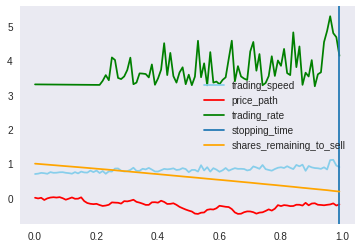

Stopping_time:  99
Total cost of execution: 2.0742214


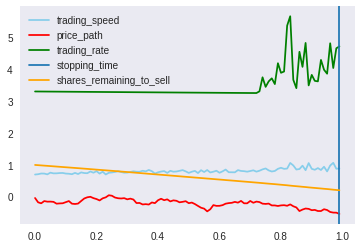

Stopping_time:  99
Total cost of execution: 2.9828758


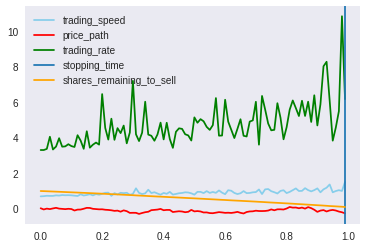

Stopping_time:  99
Total cost of execution: 2.0845776


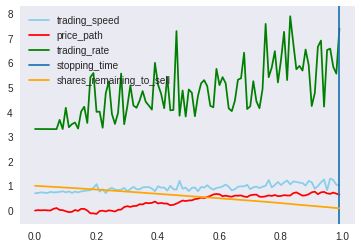

Stopping_time:  99
Total cost of execution: 2.1431842


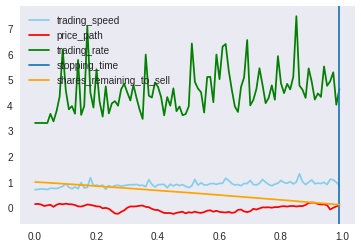

Stopping_time:  99
Total cost of execution: 2.0332088


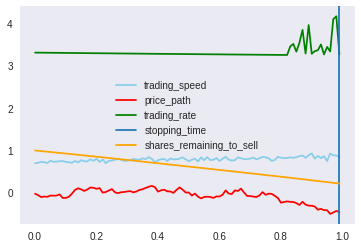

Stopping_time:  99
Total cost of execution: 1.5148317


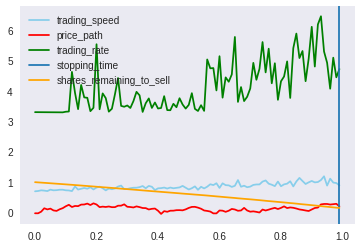

In [24]:
print_paths()